In [238]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [239]:
dataframe = pd.read_csv('https://www.lombacovid.it/story.csv')
timeseries = dataframe['ospedalizzati_story']

timeseries.describe()

count     701.000000
mean     2307.617689
std      2364.121712
min       155.000000
25%       473.000000
50%      1198.000000
75%      3865.000000
max      9340.000000
Name: ospedalizzati_story, dtype: float64

In [240]:
def compareSummaryAndVariance(order_1, order_2, fitted_timeseries):

    model = ARIMA(endog=fitted_timeseries, order=order_1)
    res_a = model.fit()
    print(res_a.summary())

    model = ARIMA(endog=fitted_timeseries, order=order_2)
    res_b = model.fit()
    print(res_b.summary())

    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
    ax[0].plot(res_a.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_a.resid.values)))
    ax[0].set_title(f"ARIMA({order_1[0]},{order_1[1]},{order_1[2]})")
    ax[0].legend()
    ax[1].plot(res_b.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_b.resid.values)))
    ax[1].set_title(f"ARIMA({order_2[0]},{order_2[1]},{order_2[2]})")
    ax[1].legend()

    return

In [241]:
def ADFTest(timeseries):

    print("If p-value < 0.05: the time series is stationary.\n")

    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    return

In [242]:
def plotACF(timeseries, differencing_times):

    plt.rcParams.update({'figure.figsize':(9,13), 'figure.dpi':80})
    fig, axes = plt.subplots(differencing_times+1, 2)

    for i in range(differencing_times+1):

        axes[i, 0].plot(timeseries)
        axes[i, 0].set_title(f"Differencing {i}")
        plot_acf(timeseries, ax=axes[i, 1], lags=20, title=f"ACF Differencing {i}")

        timeseries = timeseries.diff().dropna()

    plt.show()

In [243]:
def plotPACF(timeseries, differencing_times):

    plt.rcParams.update({'figure.figsize':(9,4), 'figure.dpi':80})
    fig, axes = plt.subplots(1, 2)

    for i in range(differencing_times+1):
        timeseries = timeseries.diff().dropna()

    axes[0].plot(timeseries)
    axes[0].set_title(f"Differencing {i}")
    plot_pacf(timeseries, ax=axes[1], lags=20, title=f"PACF Differencing {i}")

    plt.show()

# ARIMA

## How to find the order of differencing (d)

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In case you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

The logged series seems to be more flat, but is it stationary ? Let’s compute a KPSS test to check this:

In [244]:
ADFTest(timeseries)

If p-value < 0.05: the time series is stationary.

ADF Statistic: -2.235123
p-value: 0.193746


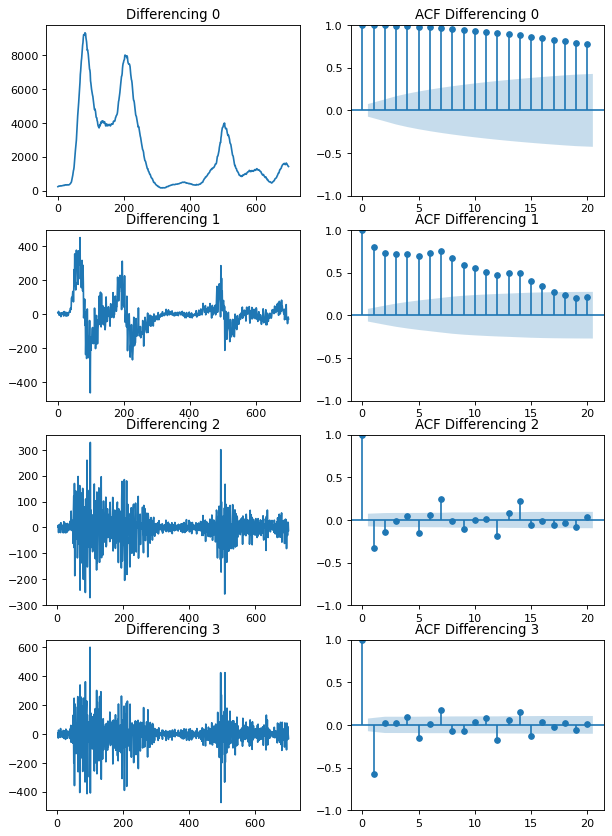

In [245]:
plotACF(timeseries, differencing_times=3)

In [246]:
ADFTest(timeseries.diff().diff().dropna())

If p-value < 0.05: the time series is stationary.

ADF Statistic: -5.146177
p-value: 0.000011


In [247]:
ADFTest(timeseries.diff().diff().diff().dropna())

If p-value < 0.05: the time series is stationary.

ADF Statistic: -11.875570
p-value: 0.000000


So d = 2 is decided.

## How to find the order of the AR term (p)

Partial autocorrelation (PACF) can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. Mathematically, PACF of lag (k) of a series is the coefficient of that lag in the autoregression equation of Y.

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


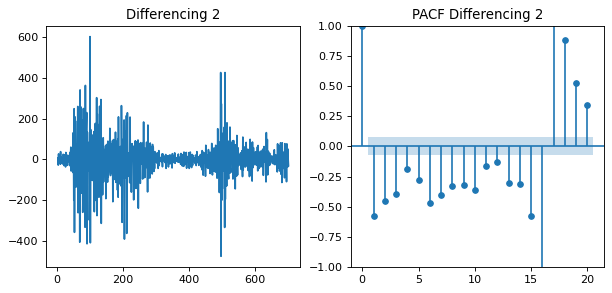

In [248]:
plotPACF(timeseries, differencing_times=2)

So p = 14 is decided.

## How to find the order of the MA term (q)

You can look at the ACF plot for the number of MA terms (an MA term is technically the error of the lagged forecast).

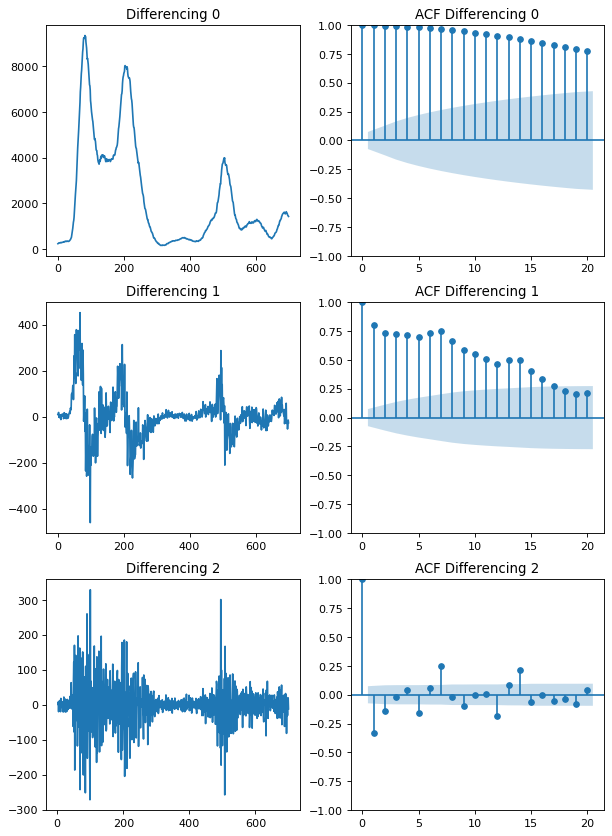

In [249]:
plotACF(timeseries, differencing_times=2)

Couple of lags are above the significance line, so:

q = 2

## The model

In [250]:
model = ARIMA(timeseries, order=(14,2,2))
model_fit = model.fit()
print(model_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     ospedalizzati_story   No. Observations:                  701
Model:                 ARIMA(14, 2, 2)   Log Likelihood               -3661.962
Date:                 Tue, 02 Aug 2022   AIC                           7357.923
Time:                         18:34:09   BIC                           7435.268
Sample:                              0   HQIC                          7387.823
                                 - 701                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4627      0.109     -4.262      0.000      -0.675      -0.250
ar.L2          0.3547      0.048      7.437      0.000       0.261       0.448
ar.L3          0.2215      0.034      6.459 

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

All the coefficients have to not be close to zero and their P-Value in the ‘P>|z|’ column has to be less than 0.05 for the respective X to be significant. We are ok!

Let’s plot the residuals to ensure there are no patterns (that is, look for constant mean and variance).

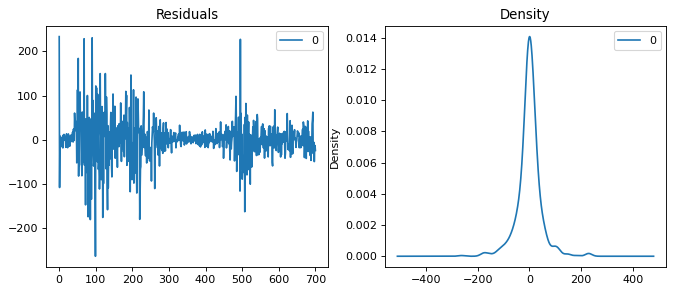

In [251]:
residuals = pd.DataFrame(model_fit.resid)

plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':80})
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## The test

/Users/stefanomartire/miniforge3/envs/lombacovid/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


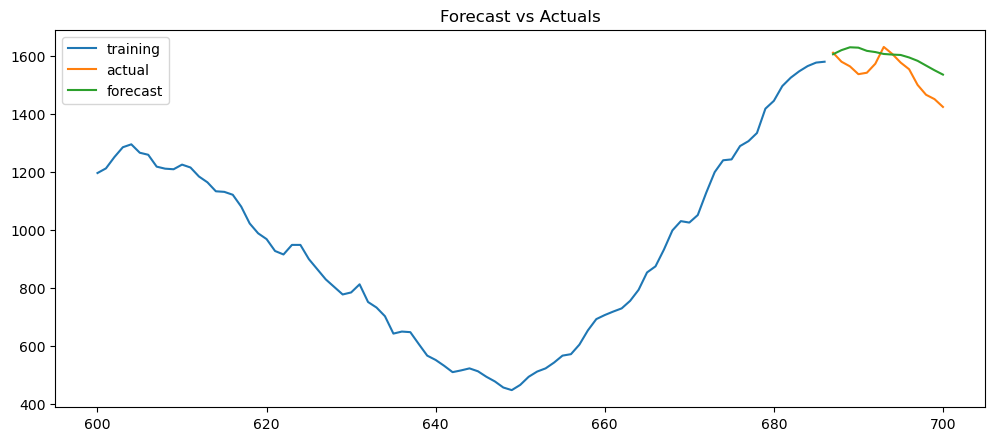

In [261]:
pred_len = 14

train = timeseries[:-pred_len]
test = timeseries[-pred_len:]

model = ARIMA(train, order=(14,2,2))
model_fit = model.fit()

model_fit.forecast(pred_len, alpha=0.05)  # 95% conf_int

fc_series = pd.Series(model_fit.forecast(pred_len, alpha=0.05), index=test.index)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train[600:], label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend()
plt.show()

# SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

We have to conduct some ADF tests on transformed data in order to stationarize the timeseries.

In [ ]:
pred_len = 7

train_set = fitted_timeseries[:-pred_len]
test_set = fitted_timeseries[-pred_len:]

NameError: name 'fitted_timeseries' is not defined

In [ ]:
sarima_model = SARIMAX(train_set, order=(12,2,2), seasonal_order=(0, 1, 2, 12), enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.get_prediction(len(fitted_timeseries.values)-pred_len+1, len(fitted_timeseries.values))
predicted_means = sarima_pred.predicted_mean

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(fitted_timeseries[650:-pred_len])
ax.plot(test_set, label='truth', color='green')
ax.plot(test_set.index, predicted_means, color='orange', linestyle='--', label="prediction")
ax.legend()
ax.set_title("SARIMA")